In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# Project: One-Mass Oscillator Optimization

## Introduction

In this project, you will apply various optimization algorithms to fit a one-mass oscillator model to real-world data. The objective is to minimize the sum of the squared residuals between the model predictions and the observed amplitudes of a one-mass oscillator system across different frequencies.

### One-Mass Oscillator Model

The one-mass oscillator is characterized by the following equation, representing the amplitudes of the system:

$$ V(\omega) = \frac{F}{\sqrt{(1 - \nu^2)^2 + 4D^2\nu^2}} $$

Here, 
- $ \omega $ represents the angular frequency of the system,
- $ \nu $ is the ratio of the excitation frequency to the natural frequency ($ \nu = \frac{\omega_{\text{err}}}{\omega_{\text{eig}}} $),
- $ D $ is the damping ratio,
- $ F $ is the force applied to the system.

The goal of the project is to determine the optimal values for the parameters $ \omega_{\text{eig}} $, $ D $, and $ F $ that result in the best fit of the one-mass oscillator model to the observed amplitudes.


### Load the real world data

- we have two different measurements
- J represents the measured frequencies
- N represents the measured amplitudes

In [2]:
df1 = pd.read_pickle("df1.pkl")
df2 = pd.read_pickle("df2.pkl")
df1

,J,N
14999,8162.504002,5.527511
15011,8156.384831,7.359789
15016,8159.199238,6.532958
15020,8159.200889,5.895933
15025,8153.934051,9.326749
15027,8154.492655,9.986718
15031,8153.330890,10.152119
15035,8152.841605,10.759362
15037,8156.021641,10.231306
15044,8156.166975,9.148720


### Low amplitudes distort the fit and are negligible therefore we define a lower threshold for N

In [3]:
threshold = 0.4
df1.sort_values("N")
max_N = max(df1["N"])
df1 = df1[df1["N"]>=threshold*max_N]


### We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable.

In [4]:
df_max=df1[df1["N"]==max(df1["N"])]
initial_Oeig = df_max["J"].values[0]
max_N = df_max["N"].values[0]

### We also have to define the other two initial guesses

In [5]:
initial_D = 0.006
initial_F = 0.120

initial_values = [initial_Oeig, initial_D, initial_F]

### Additionally we define the bounds for the decision variables



In [6]:
min_Oerr = min(df1["J"])
max_Oerr = max(df1["J"])

In [7]:
bounds = [(min_Oerr, max_Oerr), (0, 0.03), (0, 1)]

### Then we define the objective function

In [8]:
def one_mass_oscillator(params, Oerr) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    Oeig, D, F = params
    nue = Oerr / Oeig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [9]:
def objective_function(params, Oerr, amplitudes) -> np.ndarray:
    # objective function to compare calculated and real amplitudes
    return np.sum((amplitudes - one_mass_oscillator(params, Oerr)) ** 2)

### We define the options and start the optimization process

In [10]:
options = {
    "maxfun": 100000,
    "ftol": 1e-9,
    "xtol": 1e-9,
    "stepmx": 10,
    "eta": 0.25,
    "gtol": 1e-5}


In [11]:
J = np.array(df1["J"]) # measured frequency
N = np.array(df1["N"]) # measured amplitude

In [12]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='Nelder-Mead',
    bounds=bounds,
    options=options)


/var/folders/dw/pvtj6mt91znd0hftcztqb0k00000gn/T/ipykernel_69272/2959858538.py:1: OptimizeWarning: Unknown solver options: maxfun, ftol, xtol, stepmx, eta, gtol
  result = minimize(


### Then we can observe the results

In [13]:

# map optimized values to variables
resonant_frequency = result.x[0]
D = result.x[1]
F = result.x[2]
# predict the resonant amplitude with the fitted one mass oscillator.
X_pred = np.linspace(min_Oerr, max_Oerr, 1000)
ypred_one_mass_oscillator = one_mass_oscillator(result.x, X_pred)
resonant_amplitude = max(ypred_one_mass_oscillator)


In [14]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 53.5414407415841
             x: [ 8.148e+03  7.434e-04  2.153e-02]
           nit: 99
          nfev: 175
 final_simplex: (array([[ 8.148e+03,  7.434e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02]]), array([ 5.354e+01,  5.354e+01,  5.354e+01,  5.354e+01]))

### Finally, we can plot the optimized fit and the real values

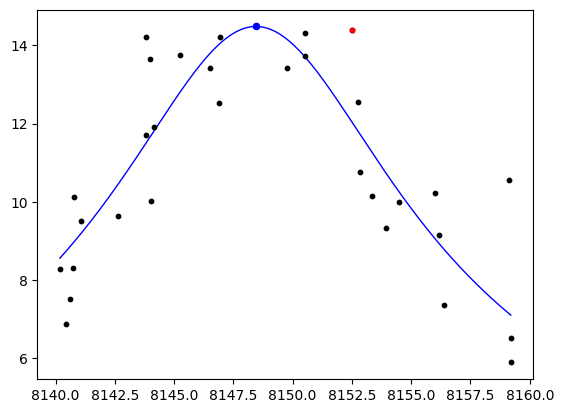

In [15]:
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
        X_pred,
        ypred_one_mass_oscillator,
        label="Alpha",
        color="blue",
        linewidth=1,
    )
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)


### Task for the Project Work

Experiment with various optimizers to identify the optimal parameter setup for the one-mass oscillator model and both data frames. Please explain your thoughts and ideas, and subsequently compare the results obtained from different optimizers.